In [200]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Plotly Plasma
In this notebook we demonstrate the use of the Plotly Plasma library to circunvent many of the shortcomings of the standard Plotly library. 

In [201]:
import pandas as pd
from plasma import plasma
import plotly.express as px
import plotly.io as pio
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pio.renderers.default = "svg"
pio.templates.default = 'plotly_white'

Lets first generate a dataset to work with

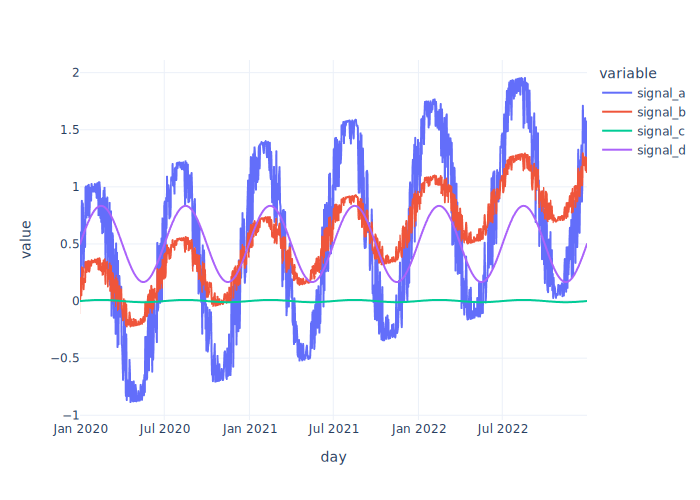

In [203]:
df_index = pd.date_range("2020-01-01", "2022-12-31", freq="D", name="day")
n_samples = df_index.shape[0]
x_array = np.linspace(-np.pi * 6, np.pi * 6, n_samples)
noise = np.random.random(df_index.shape[0])
y_array_a = np.sin(x_array + noise) + np.arange(df_index.shape[0]) / 1000
y_array_b = np.sin(x_array + noise) / 3 + np.arange(df_index.shape[0]) / 1000
y_array_c = np.sin(x_array) / 100
y_array_d = np.sin(x_array) / 3 + 0.5

data = pd.DataFrame(
    {
        "signal_a": y_array_a,
        "signal_b": y_array_b,
        "signal_c": y_array_c,
        "signal_d": y_array_d,
    },
    index=pd.Index(df_index),
).assign(year=lambda df: df.index.year)
px.line(data.drop(columns=['year']))


# Multiple y-axis
When the values of the metrics are in very different scales, plotly doesnt have an easy way to do dual axis.

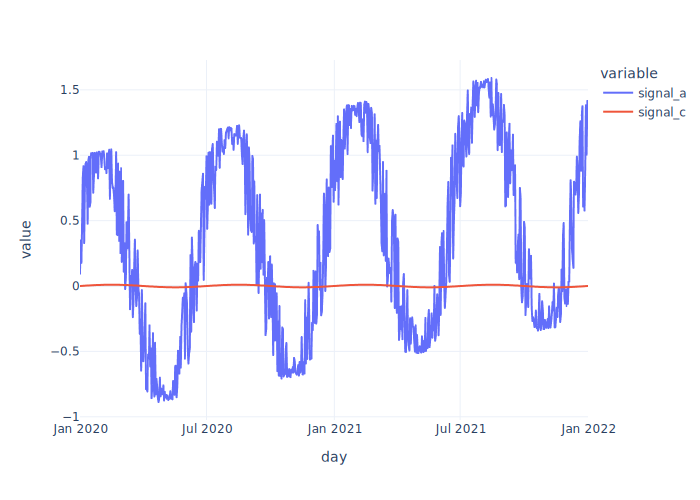

In [4]:
px.line(data[['signal_a', 'signal_c']])


## Dual axis with plotly

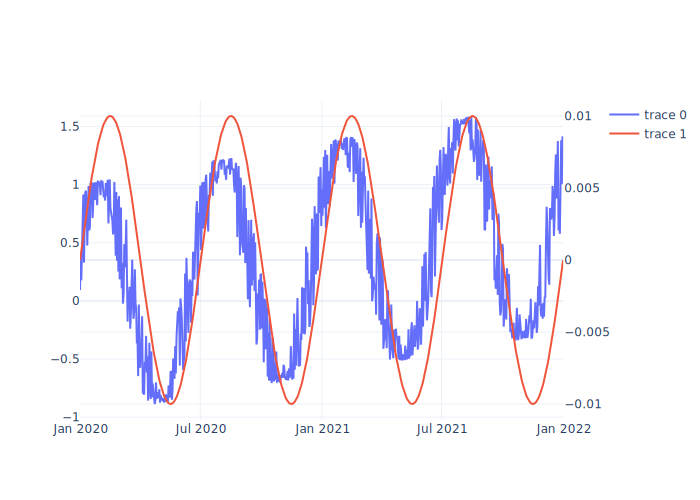

In [5]:
subplot_figure = make_subplots(rows=1, cols=1, specs=[[{"secondary_y": True}]])

subplot_figure = subplot_figure.add_trace(
    go.Scatter(x=data.index, y=data.signal_a), secondary_y=False
)

subplot_figure = subplot_figure.add_trace(
    go.Scatter(x=data.index, y=data.signal_c), secondary_y=True
)
subplot_figure


## Dual Axis with Plasma

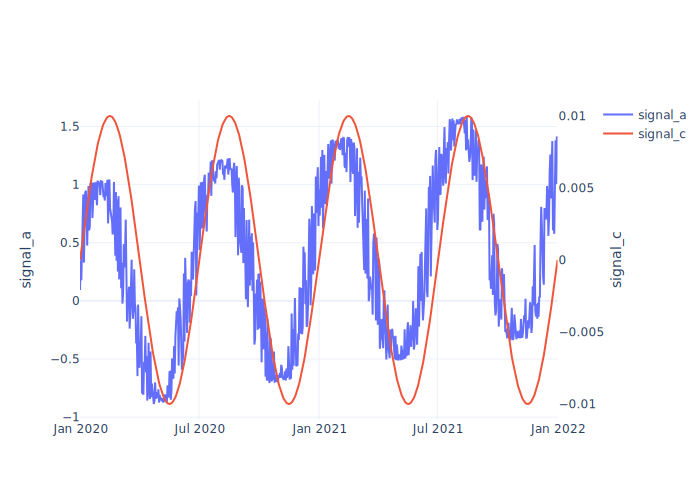

In [6]:
plasma.dual_axis_line(data, left_axis='signal_a', right_axis='signal_c')

# Markers
Labels in Plotly can be very awkward

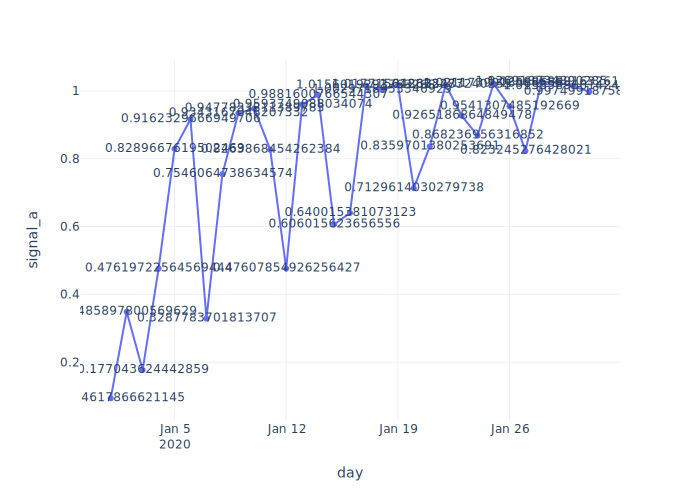

In [7]:
fig = px.line(
    data.loc["2020-01"],
    y="signal_a",
    text="signal_a",
)
fig


## Plotly markers text
The default solution is somewhat clumsy.

The argument names are not very intuitive, and the `tickformat` format string does not follow the same format as `texttemplate`

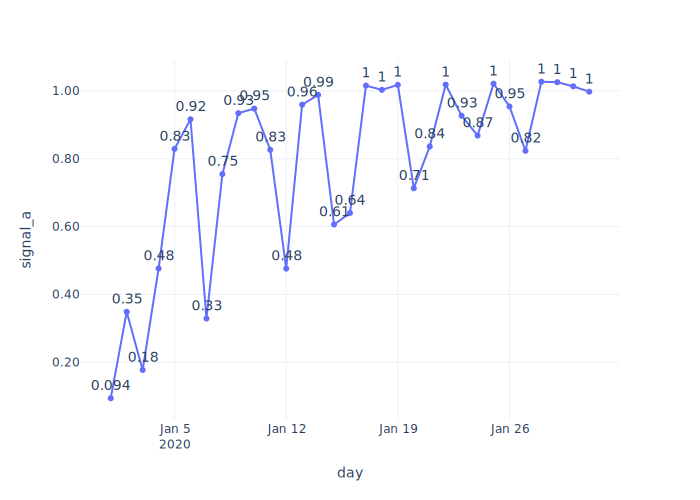

In [26]:
fig.update_traces(
    texttemplate="%{text:.2}",
    textfont=go.scatter.Textfont(size=14), # could also be just {"size": 14}
).update_yaxes(tickformat=".2f")

# Markers text with Plasma
Plasma uses the same format string as python f-strings, and will round floating numbers by default.

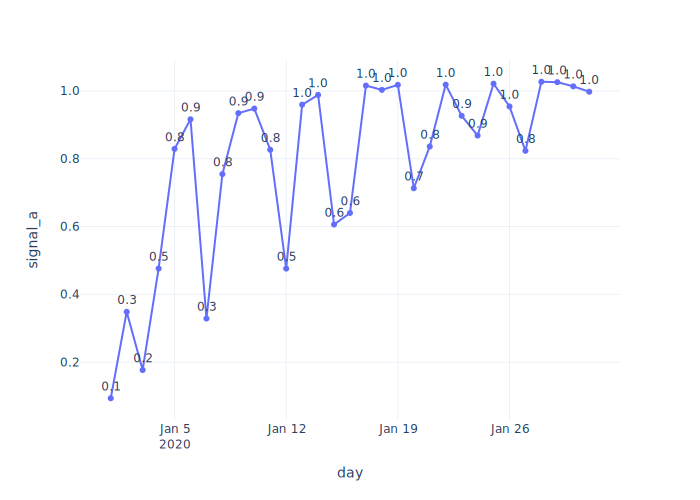

In [28]:
plasma.fix_marker_text(fig)

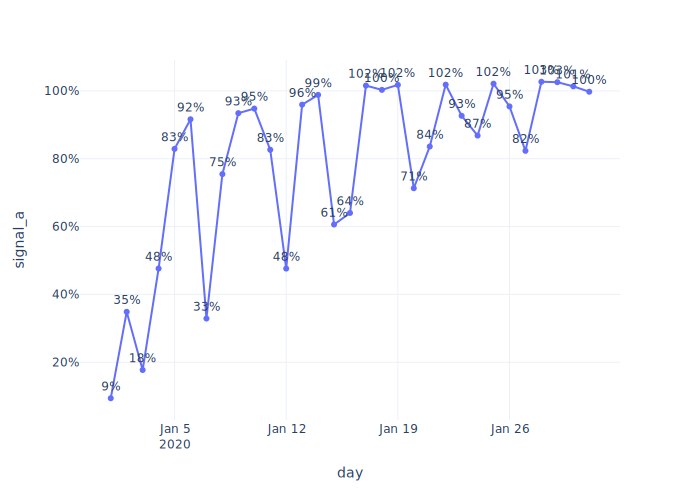

In [25]:
plasma.fix_marker_text(fig, marker_format="{:.0%}", tick_format="{:.0%}")

To keep using the fluent syntax, you can use `plasma.fluent` to add the `fix_marker_text` method to the Figure class.

In [33]:
plasma.fluent()

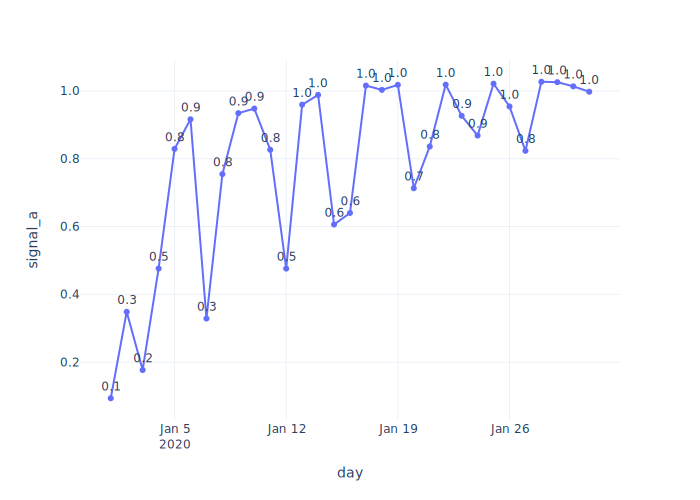

In [34]:
px.line(
    data.loc["2020-01"],
    y="signal_a",
    text="signal_a",
).fix_marker_text()

# Year-over-year comparisons
Lets try to overlay the data from different years

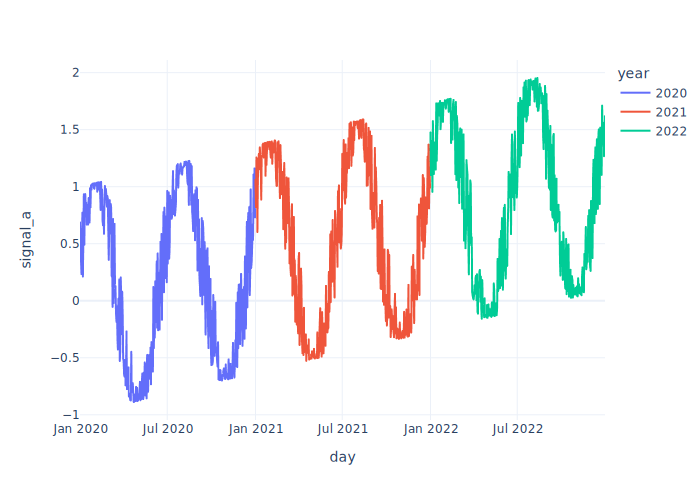

In [86]:
px.line(data, y="signal_a", color="year")


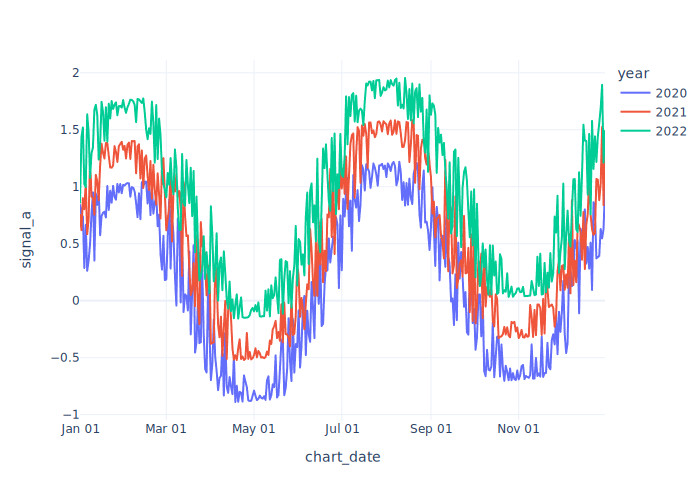

In [94]:
overlayed = data.assign(chart_date=lambda df: df.index.strftime("2020-%m-%d"))
px.line(overlayed, x="chart_date", y="signal_a", color="year").update_xaxes(
    tickformat="%b %d"
)


You can use `plasma.overlay_yoy` to achieve the same effect, but passing a DataFrame instead, as long as the date is the index.

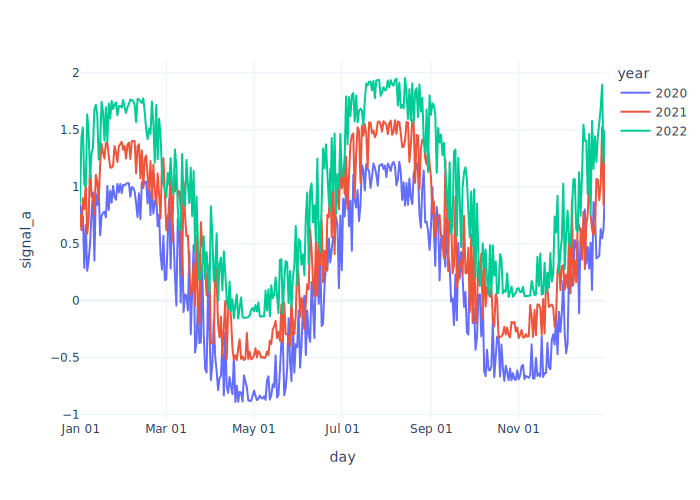

In [98]:
data.pipe(plasma.overlay_yoy, 'signal_a')

# Multiple lines as continuous color
When you have multiple lines, plotly has no easy way to color them by a continuous variable, only discrete.

In [144]:
weather = pd.read_csv(
    "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip",
    parse_dates=["Date Time"],
)


In [148]:
average_weather = (
    weather.set_index("Date Time")
    .resample("MS")["T (degC)"]
    .mean()
    .rename("mean_temp")
    .to_frame()
    .assign(month=lambda df: df.index.month, year=lambda df: df.index.year)
)


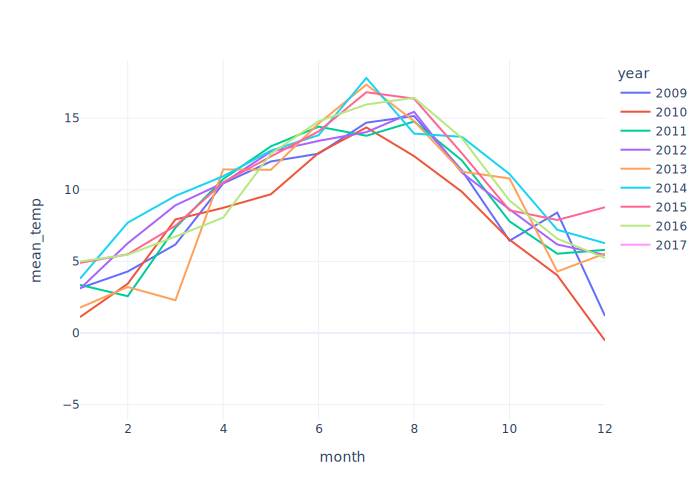

In [182]:
fig = px.line(average_weather, x="month", y="mean_temp", color="year")
fig


The workaround is to change manually the color attribute of the traces.

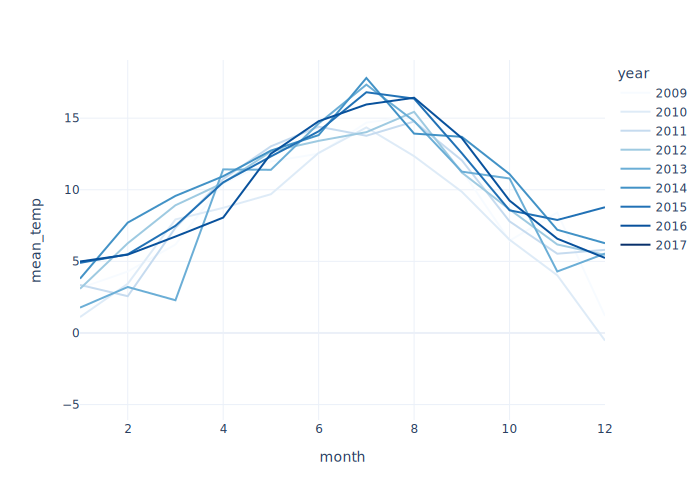

In [184]:
n_colors = average_weather.year.nunique()
colors = px.colors.sample_colorscale("Blues", n_colors)
for index, color in enumerate(colors):
    fig.data[index]["line"]["color"] = color
fig


In [190]:
plasma.fluent()

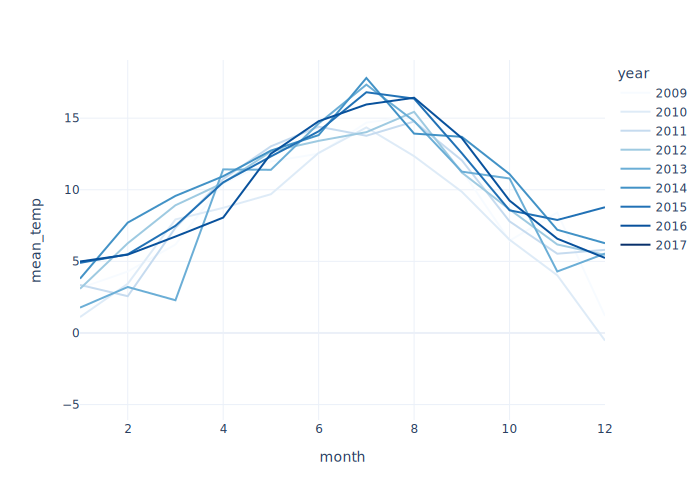

In [198]:
px.line(average_weather, x="month", y="mean_temp", color="year").continuous_lines(
    colorscale="Blues"
)


# Facets